## Capstone Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from IPython.display import display

%matplotlib inline

## Data

Data description
There are 3 types of input features:

Objective: factual information;
Examination: results of medical examination;
Subjective: information given by the patient.
Features:

    Age | Objective Feature | age | int (days)

    Height | Objective Feature | height | int (cm) |

    Weight | Objective Feature | weight | float (kg) |

    Gender | Objective Feature | gender | categorical code |

    Systolic blood pressure | Examination Feature | ap_hi | int |

    Diastolic blood pressure | Examination Feature | ap_lo | int |

    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

    Smoking | Subjective Feature | smoke | binary |

    Alcohol intake | Subjective Feature | alco | binary |

    Physical activity | Subjective Feature | active | binary |

    Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

## Data Preparation

In [2]:
df = pd.read_csv('cardio_train.csv',sep=";")

In [3]:
df.shape

(70000, 13)

In [4]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


The id is not necessary, considering we already have that data in the index of the pandas dataframe.

In [5]:
df = df.drop(df.columns[0],axis=1)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
df.dtypes

age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

Some variables are wrongly categorized. Gender, Cholestero, Glucose, Smoke, Alco, Active and Cardio should be objects.

In [7]:
gender_values = {
    1: 'woman',
    2: 'man',
}

df.gender = df.gender.map(gender_values)

In [8]:
cholesterol_values = {
    1: 'normal',
    2: 'above normal',
    3: 'well above normal'
}

df.cholesterol = df.cholesterol.map(cholesterol_values)

In [9]:
gluc_values = {
    1: 'normal',
    2: 'above normal',
    3: 'well above normal'
}

df.gluc = df.gluc.map(gluc_values)

In [10]:
cardio_values = {
    0: 'no',
    1: 'yes',
}

df.cardio = df.cardio.map(cardio_values)

The age is meassured in days in this dataset, but I think is more convenient in years.

In [11]:
df.age = np.round(df.age/365.25,decimals=1)

In [12]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.4,man,168,62.0,110,80,normal,normal,0,0,1,no
1,55.4,woman,156,85.0,140,90,well above normal,normal,0,0,1,yes
2,51.6,woman,165,64.0,130,70,well above normal,normal,0,0,0,yes
3,48.2,man,169,82.0,150,100,normal,normal,0,0,1,yes
4,47.8,woman,156,56.0,100,60,normal,normal,0,0,0,no


In [13]:
#Transforming the rest of the categorical values wrongly classified as numericals
df.smoke = df.smoke.astype('object')
df.alco = df.alco.astype('object')
df.active = df.active.astype('object')
df.cardio = df.cardio.astype('object')
df.dtypes

age            float64
gender          object
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol     object
gluc            object
smoke           object
alco            object
active          object
cardio          object
dtype: object

In [14]:
numerical_columns = ["age","height","weight", "ap_hi", "ap_lo"]
categorical_columns = ["gender","cholesterol","gluc", "smoke", "alco", "active"]
columns = numerical_columns + categorical_columns

In [15]:
df.duplicated().value_counts()

False    69326
True       674
dtype: int64

In [16]:
#"In general, try to avoid having duplicates across train-validation-test splits"
df = df.drop_duplicates()

In [17]:
#Setting up the validation framework
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [19]:
df_train

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,62.4,man,149,53.0,120,79,normal,normal,0,0,1,no
1,39.6,woman,153,90.0,110,90,normal,normal,0,0,1,no
2,43.9,man,170,80.0,120,80,normal,normal,0,0,1,no
3,48.0,woman,166,87.0,190,60,above normal,normal,0,0,1,yes
4,44.0,woman,145,40.0,120,80,normal,normal,0,0,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...
41590,62.1,woman,160,80.0,150,90,normal,normal,0,0,1,no
41591,55.7,woman,165,68.0,140,80,above normal,normal,0,0,1,yes
41592,56.3,woman,160,59.0,120,80,normal,normal,0,0,1,no
41593,64.6,woman,171,100.0,120,80,normal,normal,0,0,1,no


## EDA

In [20]:
df_full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55460 entries, 0 to 55459
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          55460 non-null  float64
 1   gender       55460 non-null  object 
 2   height       55460 non-null  int64  
 3   weight       55460 non-null  float64
 4   ap_hi        55460 non-null  int64  
 5   ap_lo        55460 non-null  int64  
 6   cholesterol  55460 non-null  object 
 7   gluc         55460 non-null  object 
 8   smoke        55460 non-null  object 
 9   alco         55460 non-null  object 
 10  active       55460 non-null  object 
 11  cardio       55460 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 5.1+ MB


In [21]:
for col in df_full_train.columns:
    print(col)
    print(f"Number of unique values : {df[col].nunique()}")
    print()

age
Number of unique values : 263

gender
Number of unique values : 2

height
Number of unique values : 109

weight
Number of unique values : 287

ap_hi
Number of unique values : 153

ap_lo
Number of unique values : 157

cholesterol
Number of unique values : 3

gluc
Number of unique values : 3

smoke
Number of unique values : 2

alco
Number of unique values : 2

active
Number of unique values : 2

cardio
Number of unique values : 2



P:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Target distribution')

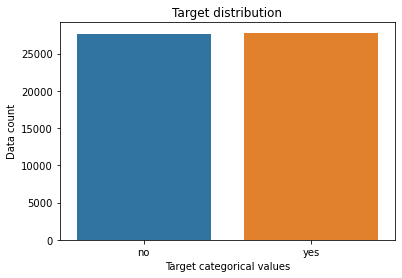

In [22]:
#Checking for data imbalance
sns.countplot(df_full_train['cardio']).set(ylabel = "Data count", xlabel = "Target categorical values")
plt.title('Target distribution')

Looking at the graph above, we don't need to balance the target.

In [23]:
df_full_train.describe().round()

,age,height,weight,ap_hi,ap_lo
count,55460.0,55460.0,55460.0,55460.0,55460.0
mean,53.0,164.0,74.0,129.0,97.0
std,7.0,8.0,14.0,162.0,194.0
min,30.0,57.0,10.0,-150.0,-70.0
25%,48.0,159.0,65.0,120.0,80.0
50%,54.0,165.0,72.0,120.0,80.0
75%,58.0,170.0,82.0,140.0,90.0
max,65.0,250.0,200.0,16020.0,11000.0


C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_23028/959543886.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_full_train.hist(bins=100, ax=ax, layout=(3, 2), column=numerical_columns)


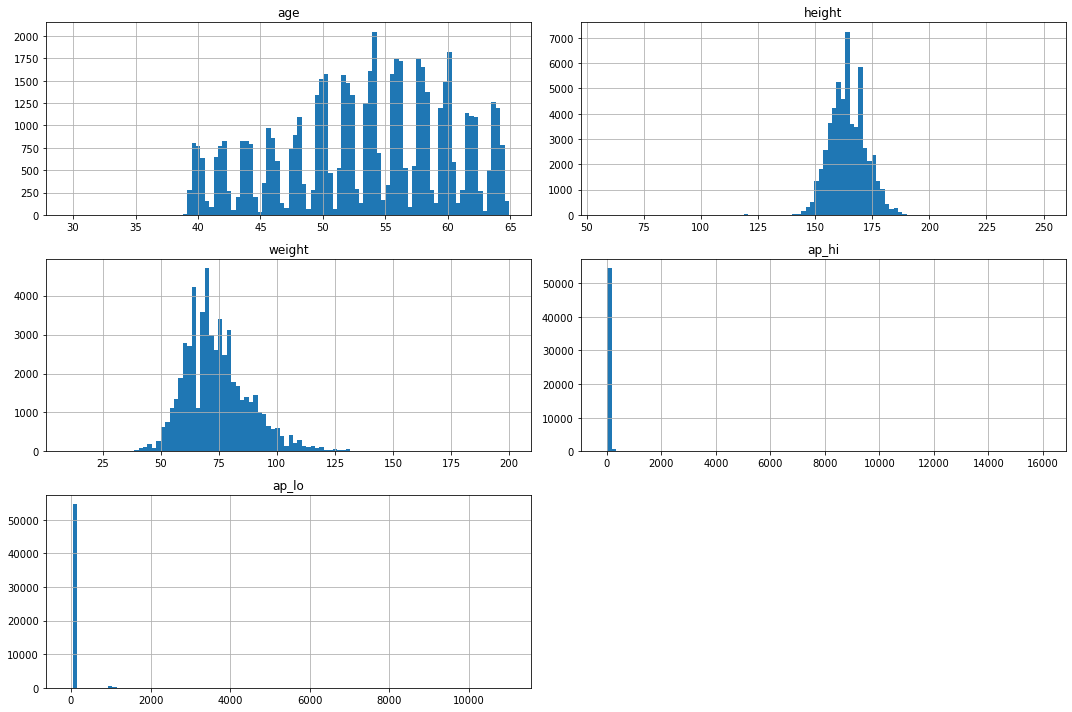

In [24]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
df_full_train.hist(bins=100, ax=ax, layout=(3, 2), column=numerical_columns)
plt.tight_layout()
plt.show()

From the above graph and table we can notice that there are some values that are way beyond and below the others. We need to deal with these outliers.

In [25]:
df_full_train.drop(df_full_train[(df_full_train['height'] > df_full_train['height'].quantile(0.99)) | (df_full_train['height'] < df_full_train['height'].quantile(0.01))].index,inplace=True)
df_full_train.drop(df_full_train[(df_full_train['weight'] > df_full_train['weight'].quantile(0.99)) | (df_full_train['weight'] < df_full_train['weight'].quantile(0.01))].index,inplace=True)
df_full_train.drop(df_full_train[(df_full_train['ap_hi'] > df_full_train['ap_hi'].quantile(0.99)) | (df_full_train['ap_hi'] < df_full_train['ap_hi'].quantile(0.01))].index,inplace=True)
df_full_train.drop(df_full_train[(df_full_train['ap_lo'] > df_full_train['ap_lo'].quantile(0.99)) | (df_full_train['ap_lo'] < df_full_train['ap_lo'].quantile(0.01))].index,inplace=True)
df_full_train.drop(df_full_train[(df_full_train['age'] > df_full_train['age'].quantile(0.99)) | (df_full_train['age'] < df_full_train['age'].quantile(0.01))].index,inplace=True)

In [26]:
df_full_train.describe().round()

,age,height,weight,ap_hi,ap_lo
count,51800.0,51800.0,51800.0,51800.0,51800.0
mean,53.0,164.0,74.0,127.0,90.0
std,7.0,7.0,13.0,16.0,89.0
min,40.0,147.0,48.0,90.0,60.0
25%,48.0,159.0,65.0,120.0,80.0
50%,54.0,165.0,72.0,120.0,80.0
75%,58.0,170.0,82.0,140.0,90.0
max,64.0,184.0,117.0,180.0,1000.0


C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_23028/959543886.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_full_train.hist(bins=100, ax=ax, layout=(3, 2), column=numerical_columns)


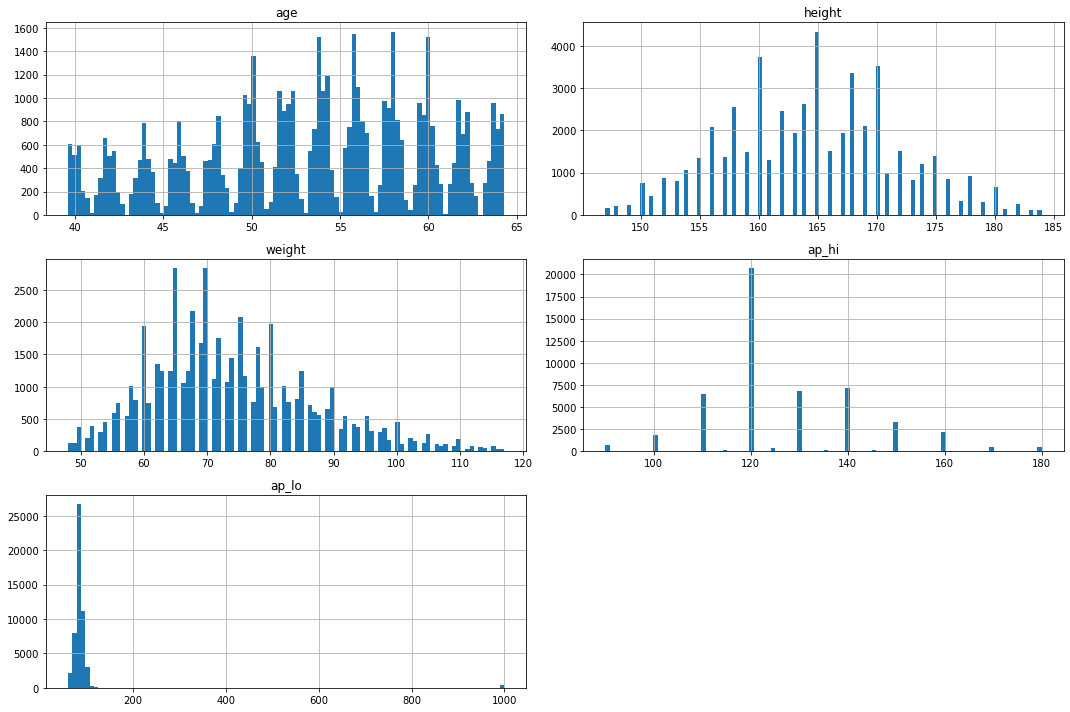

In [27]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
df_full_train.hist(bins=100, ax=ax, layout=(3, 2), column=numerical_columns)
plt.tight_layout()
plt.show()

There are still some problems with ap_hi and ap_lo

In [28]:
df_full_train.drop(df_full_train[(df_full_train['ap_lo'] > df_full_train['ap_lo'].quantile(0.98))].index,inplace=True)
df_full_train.drop(df_full_train[(df_full_train['ap_hi'] > df_full_train['ap_hi'].quantile(0.99))].index,inplace=True)

In [29]:
df_full_train.describe().round()

,age,height,weight,ap_hi,ap_lo
count,50492.0,50492.0,50492.0,50492.0,50492.0
mean,53.0,164.0,74.0,126.0,81.0
std,7.0,7.0,13.0,15.0,9.0
min,40.0,147.0,48.0,90.0,60.0
25%,48.0,159.0,65.0,120.0,80.0
50%,54.0,165.0,72.0,120.0,80.0
75%,58.0,170.0,81.0,140.0,90.0
max,64.0,184.0,117.0,170.0,100.0


C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_23028/959543886.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_full_train.hist(bins=100, ax=ax, layout=(3, 2), column=numerical_columns)


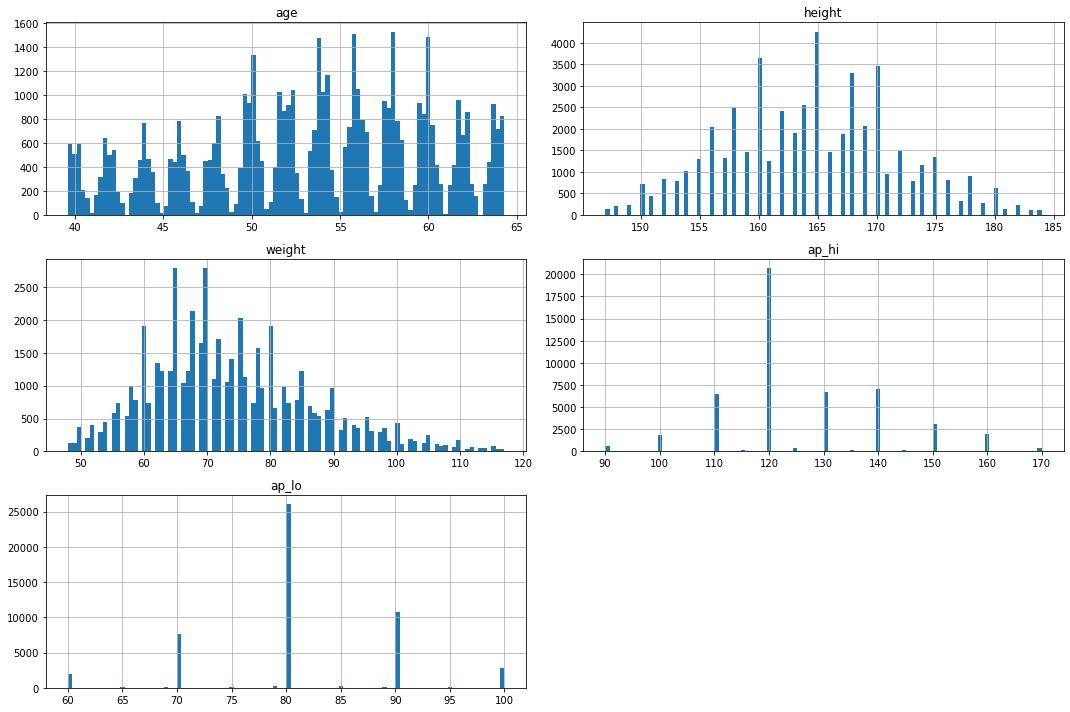

In [30]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
df_full_train.hist(bins=100, ax=ax, layout=(3, 2), column=numerical_columns)
plt.tight_layout()
plt.show()

Now the data makes more sense, so I'm going to apply these rules to the different sets.

In [31]:
df_train.drop(df_train[(df_train['height'] > df_train['height'].quantile(0.99)) | (df_train['height'] < df_train['height'].quantile(0.01))].index,inplace=True)
df_train.drop(df_train[(df_train['weight'] > df_train['weight'].quantile(0.99)) | (df_train['weight'] < df_train['weight'].quantile(0.01))].index,inplace=True)
df_train.drop(df_train[(df_train['ap_hi'] > df_train['ap_hi'].quantile(0.99)) | (df_train['ap_hi'] < df_train['ap_hi'].quantile(0.01))].index,inplace=True)
df_train.drop(df_train[(df_train['ap_lo'] > df_train['ap_lo'].quantile(0.99)) | (df_train['ap_lo'] < df_train['ap_lo'].quantile(0.01))].index,inplace=True)
df_train.drop(df_train[(df_train['ap_lo'] > df_train['ap_lo'].quantile(0.98))].index,inplace=True)
df_train.drop(df_train[(df_train['ap_hi'] > df_train['ap_hi'].quantile(0.99))].index,inplace=True)
df_train.drop(df_train[(df_train['age'] > df_train['age'].quantile(0.99)) | (df_train['age'] < df_train['age'].quantile(0.01))].index,inplace=True)

df_val.drop(df_val[(df_val['height'] > df_val['height'].quantile(0.99)) | (df_val['height'] < df_val['height'].quantile(0.01))].index,inplace=True)
df_val.drop(df_val[(df_val['weight'] > df_val['weight'].quantile(0.99)) | (df_val['weight'] < df_val['weight'].quantile(0.01))].index,inplace=True)
df_val.drop(df_val[(df_val['ap_hi'] > df_val['ap_hi'].quantile(0.99)) | (df_val['ap_hi'] < df_val['ap_hi'].quantile(0.01))].index,inplace=True)
df_val.drop(df_val[(df_val['ap_lo'] > df_val['ap_lo'].quantile(0.99)) | (df_val['ap_lo'] < df_val['ap_lo'].quantile(0.01))].index,inplace=True)
df_val.drop(df_val[(df_val['ap_lo'] > df_val['ap_lo'].quantile(0.98))].index,inplace=True)
df_val.drop(df_val[(df_val['ap_hi'] > df_val['ap_hi'].quantile(0.99))].index,inplace=True)
df_val.drop(df_val[(df_val['age'] > df_val['age'].quantile(0.99)) | (df_val['age'] < df_val['age'].quantile(0.01))].index,inplace=True)

df_test.drop(df_test[(df_test['height'] > df_test['height'].quantile(0.99)) | (df_test['height'] < df_test['height'].quantile(0.01))].index,inplace=True)
df_test.drop(df_test[(df_test['weight'] > df_test['weight'].quantile(0.99)) | (df_test['weight'] < df_test['weight'].quantile(0.01))].index,inplace=True)
df_test.drop(df_test[(df_test['ap_hi'] > df_test['ap_hi'].quantile(0.99)) | (df_test['ap_hi'] < df_test['ap_hi'].quantile(0.01))].index,inplace=True)
df_test.drop(df_test[(df_test['ap_lo'] > df_test['ap_lo'].quantile(0.99)) | (df_test['ap_lo'] < df_test['ap_lo'].quantile(0.01))].index,inplace=True)
df_test.drop(df_test[(df_test['ap_lo'] > df_test['ap_lo'].quantile(0.98))].index,inplace=True)
df_test.drop(df_test[(df_test['ap_hi'] > df_test['ap_hi'].quantile(0.99))].index,inplace=True)
df_test.drop(df_test[(df_test['age'] > df_test['age'].quantile(0.99)) | (df_test['age'] < df_test['age'].quantile(0.01))].index,inplace=True)

In [32]:
#Mutual Information
def mutual_info_target_score(series):
    return mutual_info_score(series, df_full_train.cardio)
mi_scores = df_full_train[categorical_columns].apply(mutual_info_target_score)
mi_scores.sort_values(ascending=False).round(4).to_frame(name='Mutual Info')

,Mutual Info
cholesterol,0.0242
gluc,0.0036
active,0.0007
smoke,0.0002
alco,0.0001
gender,0.0000


The feature most related with the presence or absence of cardiovascular disease is the amount of cholesterol the person has.

In [33]:
#Transforming the target to numerical data, that way it can be correlated with the numerical features
cardio_values_numeric = {
    'no': 0 ,
    'yes': 1 ,
}
df_full_train_target_as_numeric = df_full_train.copy(deep=True)
df_full_train_target_as_numeric.cardio = df_full_train_target_as_numeric.cardio.map(cardio_values_numeric).astype('int64')
df_full_train_target_as_numeric.corr()

,age,height,weight,ap_hi,ap_lo,cardio
age,1.000000,-0.085529,0.069772,0.212042,0.157015,0.233666
height,-0.085529,1.000000,0.285050,0.011074,0.025063,-0.017649
weight,0.069772,0.285050,1.000000,0.249784,0.231254,0.169716
ap_hi,0.212042,0.011074,0.249784,1.000000,0.716982,0.431119
ap_lo,0.157015,0.025063,0.231254,0.716982,1.000000,0.335995
cardio,0.233666,-0.017649,0.169716,0.431119,0.335995,1.000000


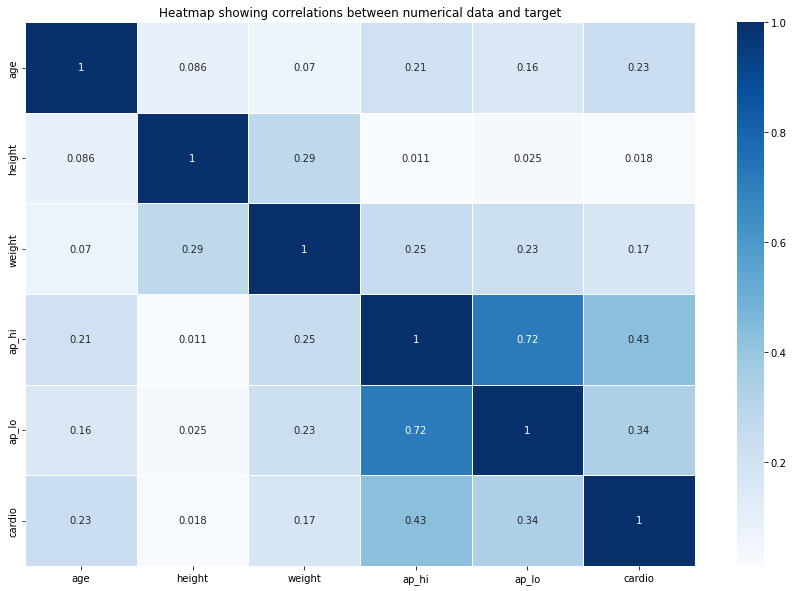

In [34]:
corr = df_full_train_target_as_numeric.corr().abs()

plt.figure(figsize=(15,10))  
sns.heatmap(corr,annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data and target')
plt.show()

From the graph and table above, we can see that both blood pressure meditions are highly correlated with the presence or absence of cardiovascular disease and they additionally are highly related between them.

In [35]:
#I left this section at the bottom because I don't know how to drop the same indexes in the y's that were dropped 
# when eliminating the outliers from the df's
df_full_train.cardio = df_full_train.cardio.astype('object')
df_train.cardio = df_train.cardio.astype('object')
df_val.cardio = df_val.cardio.astype('object')
df_test.cardio = df_test.cardio.astype('object')

y_train = df_train.cardio.values
y_val = df_val.cardio.values
y_full_train = df_full_train.cardio.values
y_test = df_test.cardio.values

del df_train['cardio']
del df_val['cardio']
del df_test['cardio']
del df_full_train['cardio']


## One Hot Encoding

In [36]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [37]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((37826, 16), (12655, 16), (37826,), (12655,))

## Logistic Regression

In [38]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_val = lr.predict_proba(X_val)[:,1]
auc_val = roc_auc_score(y_val, y_pred_val)
y_pred_train = lr.predict_proba(X_train)[:,1]
auc_train = roc_auc_score(y_train, y_pred_train)
print(f"AUC train data: {round(auc_train,3)}")
print(f"AUC val data: {round(auc_val,3)}")

AUC train data: 0.772
AUC val data: 0.774


P:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Parameter Turning LR 

In [39]:
#Tuning C for solver lbfgs
print("solver lbfgs")
scores = []
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='lbfgs', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred_val = model.predict_proba(X_val)[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    y_pred_train = model.predict_proba(X_train)[:,1]
    auc_train = roc_auc_score(y_train, y_pred_train)
    print(f'C = {C}  AUC-train = {round(auc_train,3)}  AUC-val = {round(auc_val,3)}')

solver lbfgs
C = 0.001  AUC-train = 0.783  AUC-val = 0.786


P:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C = 0.01  AUC-train = 0.785  AUC-val = 0.788


P:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C = 0.1  AUC-train = 0.785  AUC-val = 0.787
C = 1  AUC-train = 0.785  AUC-val = 0.787
C = 10  AUC-train = 0.785  AUC-val = 0.788
C = 100  AUC-train = 0.785  AUC-val = 0.788


In [40]:
#Tuning C for solver liblinear
print("solver liblinear")
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred_val = model.predict_proba(X_val)[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    y_pred_train = model.predict_proba(X_train)[:,1]
    auc_train = roc_auc_score(y_train, y_pred_train)
    print(f'C = {C}  AUC-train = {round(auc_train,3)}  AUC-val = {round(auc_val,3)}')

solver liblinear
C = 0.001  AUC-train = 0.768  AUC-val = 0.772
C = 0.01  AUC-train = 0.775  AUC-val = 0.778
C = 0.1  AUC-train = 0.783  AUC-val = 0.786
C = 1  AUC-train = 0.785  AUC-val = 0.788
C = 10  AUC-train = 0.785  AUC-val = 0.788
C = 100  AUC-train = 0.785  AUC-val = 0.788


In [41]:
#Tuning C for solver newton-cg
print("solver newton-cg")
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='newton-cg', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred_val = model.predict_proba(X_val)[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    y_pred_train = model.predict_proba(X_train)[:,1]
    auc_train = roc_auc_score(y_train, y_pred_train)
    print(f'C = {C}  AUC-train = {round(auc_train,3)}  AUC-val = {round(auc_val,3)}')

solver newton-cg
C = 0.001  AUC-train = 0.783  AUC-val = 0.786
C = 0.01  AUC-train = 0.785  AUC-val = 0.788


P:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
P:\Anaconda\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


C = 0.1  AUC-train = 0.785  AUC-val = 0.788
C = 1  AUC-train = 0.785  AUC-val = 0.788
C = 10  AUC-train = 0.785  AUC-val = 0.788
C = 100  AUC-train = 0.785  AUC-val = 0.788


P:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
P:\Anaconda\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [42]:
#Tuning C for solver sag
print("solver sag")
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='sag', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred_val = model.predict_proba(X_val)[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    y_pred_train = model.predict_proba(X_train)[:,1]
    auc_train = roc_auc_score(y_train, y_pred_train)
    print(f'C = {C}  AUC-train = {round(auc_train,3)}  AUC-val = {round(auc_val,3)}')
    

solver sag


P:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


C = 0.001  AUC-train = 0.776  AUC-val = 0.78
C = 0.01  AUC-train = 0.777  AUC-val = 0.78


P:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


C = 0.1  AUC-train = 0.782  AUC-val = 0.784


P:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


C = 1  AUC-train = 0.782  AUC-val = 0.785


P:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


C = 10  AUC-train = 0.783  AUC-val = 0.785
C = 100  AUC-train = 0.783  AUC-val = 0.785


P:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


#### The best results for the AUC's were for C =  0.01 and solver = lbfgs (the default one)

## Decision Tree

In [43]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_val = dt.predict_proba(X_val)[:,1]
auc_val = roc_auc_score(y_val, y_pred_val)
y_pred_train = dt.predict_proba(X_train)[:,1]
auc_train = roc_auc_score(y_train, y_pred_train)
print(f"AUC train data: {round(auc_train,3)}")
print(f"AUC val data: {round(auc_val,3)}")

AUC train data: 1.0
AUC val data: 0.633


These results are expected from a DT with a large depth

## Parameter Turning DT

In [44]:
#max depth
for md in [1, 2, 3 ,4, 5, 6, 7, 8, 9, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=md)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    y_pred_train = dt.predict_proba(X_train)[:, 1]
    auc_train = roc_auc_score(y_train, y_pred_train)
    print(f'max_dept = {md}  AUC-train = {round(auc_train,3)}  AUC-val = {round(auc_val,3)}')

max_dept = 1  AUC-train = 0.706  AUC-val = 0.633
max_dept = 2  AUC-train = 0.758  AUC-val = 0.633
max_dept = 3  AUC-train = 0.771  AUC-val = 0.633
max_dept = 4  AUC-train = 0.781  AUC-val = 0.633
max_dept = 5  AUC-train = 0.788  AUC-val = 0.633
max_dept = 6  AUC-train = 0.793  AUC-val = 0.633
max_dept = 7  AUC-train = 0.798  AUC-val = 0.633
max_dept = 8  AUC-train = 0.805  AUC-val = 0.633
max_dept = 9  AUC-train = 0.813  AUC-val = 0.633
max_dept = 10  AUC-train = 0.823  AUC-val = 0.633
max_dept = 15  AUC-train = 0.9  AUC-val = 0.633
max_dept = 20  AUC-train = 0.969  AUC-val = 0.633
max_dept = None  AUC-train = 1.0  AUC-val = 0.633


The best depth is between 4 and 10

In [45]:
#min_sample_leaf
scores = []
for depth in list(range(4,11)):
    for s in [1, 5, 10, 15, 20, 25, 100, 200, 250, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        y_pred_train = dt.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred_train)    
        scores.append((depth, s, auc_train, auc))
columns = ['max_depth', 'min_samples_leaf', 'AUC_train', 'AUC_val']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['AUC_train', 'AUC_val'])

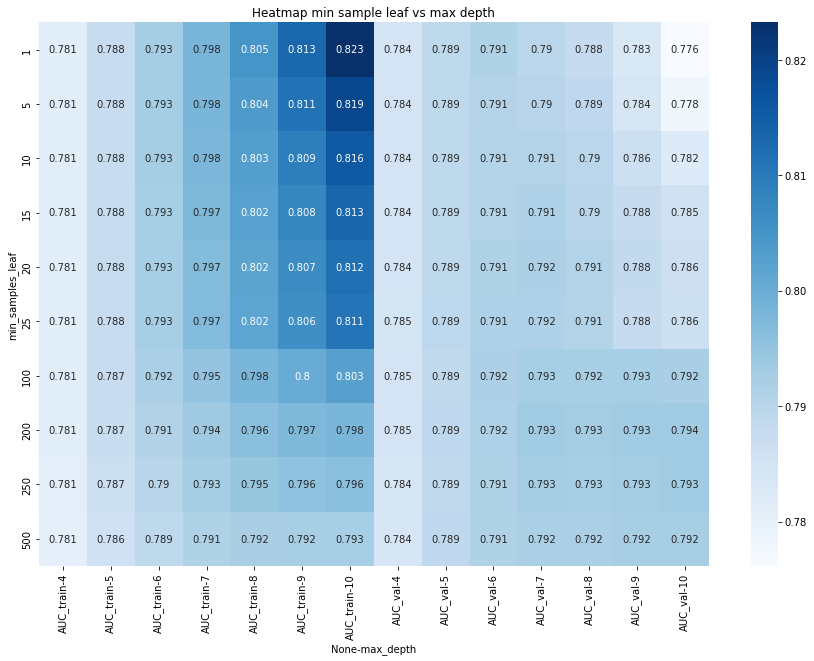

In [46]:
plt.figure(figsize=(15,10))  
sns.heatmap(df_scores_pivot, annot=True, cmap='Blues', fmt='.3g')
plt.title('Heatmap min sample leaf vs max depth')
plt.show()

#### The best parameters are max depth 9 and min sample leaf 100

## Random Forest

In [47]:
rf =RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_val = rf.predict_proba(X_val)[:,1]
auc_val = roc_auc_score(y_val, y_pred_val)
y_pred_train = rf.predict_proba(X_train)[:,1]
auc_train = roc_auc_score(y_train, y_pred_train)
print(f"AUC train data: {round(auc_train,3)}")
print(f"AUC val data: {round(auc_val,3)}")

AUC train data: 1.0
AUC val data: 0.762


## Parameter Turning RF

In [48]:
#random state and number of estimators
scores = []
for r in [1, 3, 5, 10]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, random_state=r, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        y_pred_train = rf.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred_train)
        scores.append((n, r, auc_train, auc))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'random_state', 'AUC_train', 'AUC_val'])

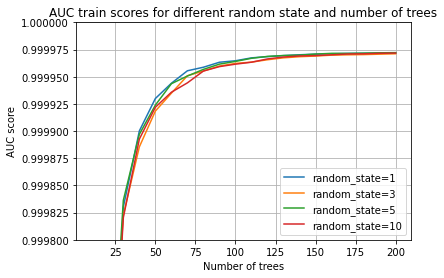

In [49]:
for r in [1, 3, 5, 10]:
    df_subset = df_scores[df_scores.random_state == r]
    plt.plot(df_subset.n_estimators, df_subset['AUC_train'], label=f'random_state={r}')
    plt.ylim(0.9998, 1)
plt.legend()
plt.title('AUC train scores for different random state and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')
plt.grid()

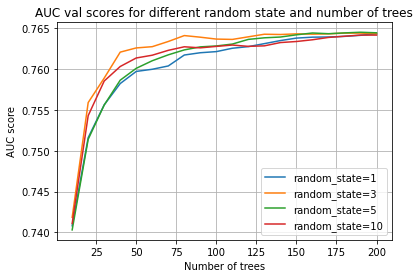

In [50]:
for r in [1, 3, 5, 10]:
    df_subset = df_scores[df_scores.random_state == r]
    plt.plot(df_subset.n_estimators, df_subset.AUC_val, label=f'random_state={r}')
plt.legend()
plt.title('AUC val scores for different random state and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')
plt.grid()

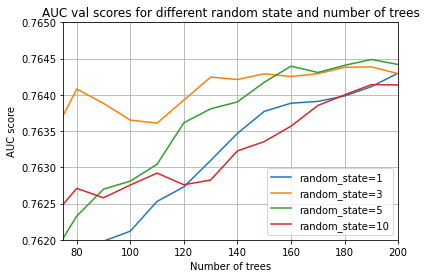

In [51]:
for r in [1, 3, 5, 10]:
    df_subset = df_scores[df_scores.random_state == r]
    plt.plot(df_subset.n_estimators, df_subset.AUC_val, label=f'random_state={r}')
    plt.ylim(0.762, 0.765)
    plt.xlim(75, 200)
plt.title('AUC val scores for different random state and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')
plt.legend()
plt.grid()

From these graphs, we can conclude that the best random state is 3 with 80 trees.

In [52]:
#max depth and number of estimators
r = 3
scores = []
for d in [1, 5, 10, 15, 20]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=r, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        y_pred_train = rf.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred_train)        
        scores.append((d, n, auc_train, auc))

In [53]:
columns = ['max_depth', 'n_estimators', 'AUC_train', 'AUC_val']
df_scores = pd.DataFrame(scores, columns=columns)

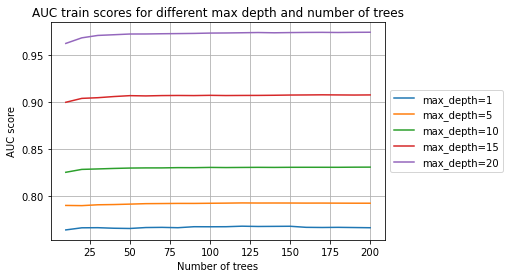

In [54]:
for d in [1, 5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.AUC_train, label = f'max_depth={d}')
plt.title('AUC train scores for different max depth and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

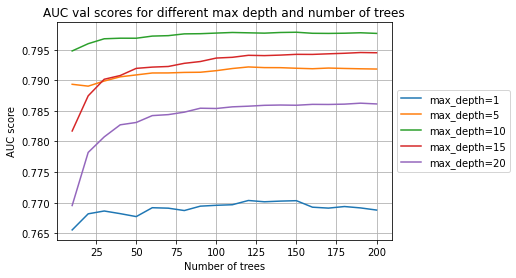

In [55]:
for d in [1, 5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.AUC_val, label = f'max_depth={d}')
plt.title('AUC val scores for different max depth and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

From the graphs, max depth = 10 and 75 trees gives the best results.

In [56]:
#min sample leaf and number of trees
max_depth = 10
r = 3
scores = []
for s in [1, 3, 5, 10, 50, 100]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=r, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        y_pred_train = rf.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred_train) 
        scores.append((s, n, auc_train, auc))

In [57]:
columns = ['min_samples_leaf', 'n_estimators', 'AUC_train', 'AUC_val']
df_scores = pd.DataFrame(scores, columns=columns)

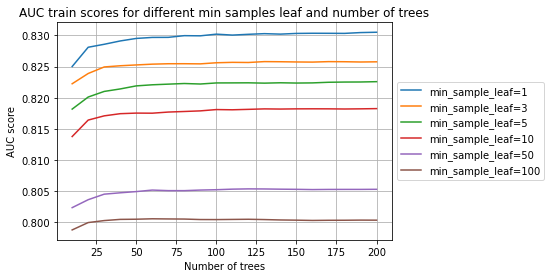

In [58]:
for s in [1, 3, 5, 10, 50, 100]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.AUC_train, label = f'min_sample_leaf={s}')
plt.title('AUC train scores for different min samples leaf and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')       
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

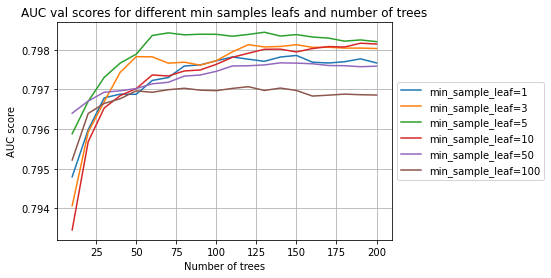

In [59]:
for s in [1, 3, 5, 10, 50, 100]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.AUC_val, label=f'min_sample_leaf={s}')
plt.title('AUC val scores for different min samples leafs and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

From the graphs, the best one is min samples leaf is 3 at 75 trees.

In [60]:
#max_features and number of trees
scores = []
r = 3 
md = 10
s = 3
for f in [1, 3, 5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=md, max_features=f, min_samples_leaf=s, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        y_pred_train = rf.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred_train)
        scores.append((f, n, auc_train, auc))

In [61]:
columns = ['max_features', 'n_estimators', 'AUC_train', 'AUC_val']
df_scores = pd.DataFrame(scores, columns=columns)

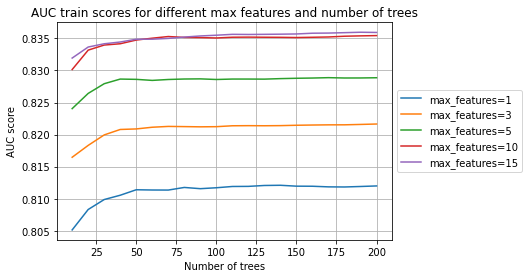

In [62]:
for f in [1, 3, 5, 10, 15]:
    df_subset = df_scores[df_scores.max_features == f]
    plt.plot(df_subset.n_estimators, df_subset.AUC_train, label = f'max_features={f}')
plt.title('AUC train scores for different max features and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')       
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

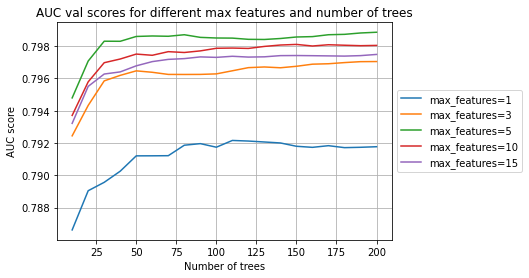

In [63]:
for f in [1, 3, 5, 10, 15]:
    df_subset = df_scores[df_scores.max_features == f]
    plt.plot(df_subset.n_estimators, df_subset.AUC_val, label = f'max_features={f}')
plt.title('AUC val scores for different max features and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

From the graphs, the best one is 5 max features at 80 trees.

#### Considering all the above, the best results where obtained with:

Random State = 3 

Max Depth = 10

Min samples leaf = 3

Max Features = 5

Number of trees = 80

## ExtraTrees Classifier

In [64]:
et = ExtraTreesClassifier() 
et.fit(X_train, y_train)
y_pred_val = et.predict_proba(X_val)[:,1]
auc_val = roc_auc_score(y_val, y_pred_val)
y_pred_train = et.predict_proba(X_train)[:,1]
auc_train = roc_auc_score(y_train, y_pred_train)
print(f"AUC train data: {round(auc_train,3)}")
print(f"AUC val data: {round(auc_val,3)}")

AUC train data: 1.0
AUC val data: 0.744


## Parameter Turning ET

In [65]:
#random state and number of estimators
scores = []
for r in [1, 3, 5, 10]:
    for n in range(10, 201, 10):
        et =  ExtraTreesClassifier(n_estimators=n, random_state=r, n_jobs=-1)
        et.fit(X_train, y_train)
        y_pred = et.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        y_pred_train = et.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred_train)
        scores.append((n, r, auc_train, auc))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'random_state','AUC_train', 'AUC_val'])

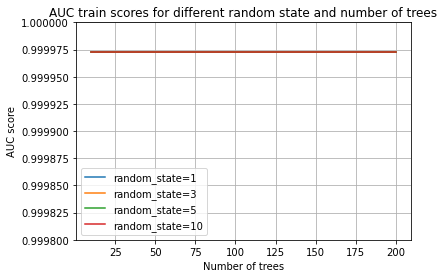

In [66]:
for r in [1, 3, 5, 10]:
    df_subset = df_scores[df_scores.random_state == r]
    plt.plot(df_subset.n_estimators, df_subset['AUC_train'], label=f'random_state={r}')
    plt.ylim(0.9998, 1)
plt.legend()
plt.title('AUC train scores for different random state and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')
plt.grid()

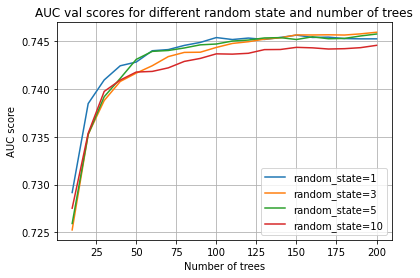

In [67]:
for r in [1, 3, 5, 10]:
    df_subset = df_scores[df_scores.random_state == r]
    plt.plot(df_subset.n_estimators, df_subset.AUC_val, label=f'random_state={r}')
plt.legend()
plt.title('AUC val scores for different random state and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')
plt.grid()

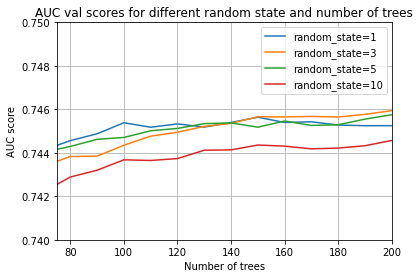

In [68]:
for r in [1, 3, 5, 10]:
    df_subset = df_scores[df_scores.random_state == r]
    plt.plot(df_subset.n_estimators, df_subset.AUC_val, label=f'random_state={r}')
    plt.ylim(0.740, 0.750)
    plt.xlim(75, 200)
plt.title('AUC val scores for different random state and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')
plt.legend()
plt.grid()

From these graphs, we can conclude that the best random state is 1 with 100 trees.

In [69]:
#max depth and number of estimators
r = 1
scores = []
for d in [1, 5, 10, 15, 20]:
    for n in range(10, 201, 10):
        et = ExtraTreesClassifier(n_estimators=n, max_depth=d, random_state=r, n_jobs=-1)
        et.fit(X_train, y_train)
        y_pred = et.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        y_pred_train = et.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred_train)        
        scores.append((d, n, auc_train, auc))

In [70]:
columns = ['max_depth', 'n_estimators', 'AUC_train', 'AUC_val']
df_scores = pd.DataFrame(scores, columns=columns)

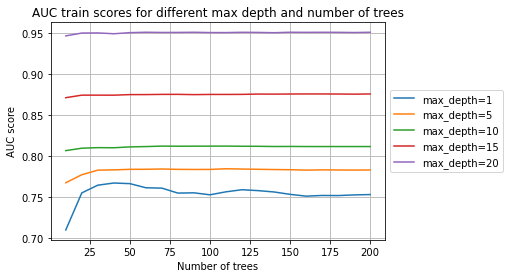

In [71]:
for d in [1, 5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.AUC_train, label=f'max_depth={d}')
plt.title('AUC train scores for different max depth and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

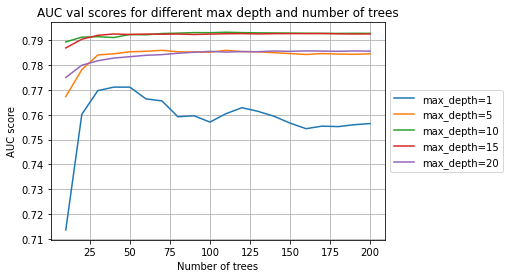

In [72]:
for d in [1, 5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.AUC_val, label=f'max_depth={d}')
plt.title('AUC val scores for different max depth and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

From the graphs, max depth = 10 and 15 are similar, so I'm going choose max_depth= 10 because its less overfitted and 50 trees 

In [73]:
#min sample leaf and number of trees
max_depth = 10
r = 1
scores = []
for s in [1, 3, 5, 10, 50, 100]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=r, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        y_pred_train = rf.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred_train) 
        scores.append((s, n, auc_train, auc))

In [74]:
columns = ['min_samples_leaf', 'n_estimators', 'AUC_train', 'AUC_val']
df_scores = pd.DataFrame(scores, columns=columns)

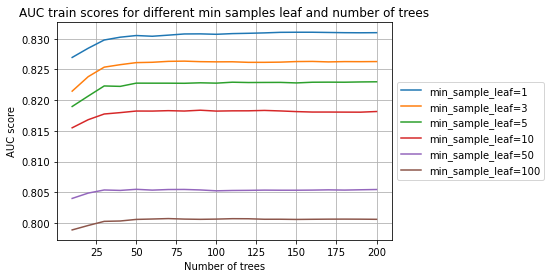

In [75]:
for s in [1, 3, 5, 10, 50, 100]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.AUC_train, label=f'min_sample_leaf={s}')
plt.title('AUC train scores for different min samples leaf and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')       
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

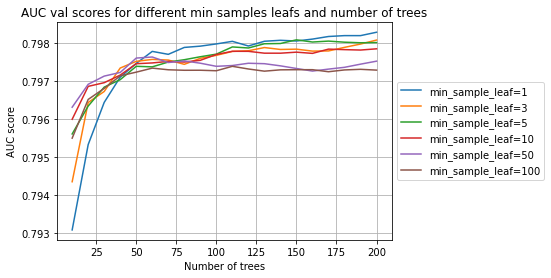

In [76]:
for s in [1, 3, 5, 10, 50, 100]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.AUC_val, label=f'min_sample_leaf={s}')
plt.title('AUC val scores for different min samples leafs and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

From the graphs, the best one is min samples leaf is 1 at 110 trees.

In [77]:
#max_features and number of trees
scores = []
md = 10
r = 1
s = 1
for f in [1, 3, 5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=md, max_features=f, min_samples_leaf=s, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        y_pred_train = rf.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred_train)
        scores.append((f, n, auc_train, auc))

In [78]:
columns = ['max_features', 'n_estimators', 'AUC_train', 'AUC_val']
df_scores = pd.DataFrame(scores, columns=columns)

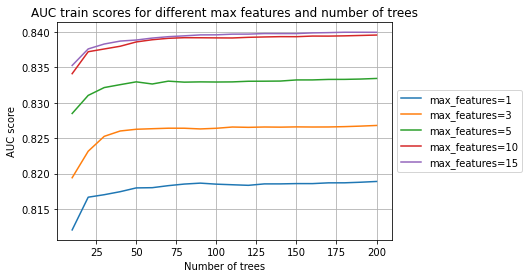

In [79]:
for f in [1, 3, 5, 10, 15]:
    df_subset = df_scores[df_scores.max_features == f]
    plt.plot(df_subset.n_estimators, df_subset.AUC_train, label=f'max_features={f}')
plt.title('AUC train scores for different max features and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')       
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

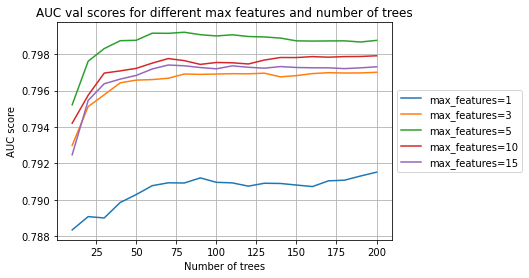

In [80]:
for f in [1, 3, 5, 10, 15]:
    df_subset = df_scores[df_scores.max_features == f]
    plt.plot(df_subset.n_estimators, df_subset.AUC_val, label=f'max_features={f}')
plt.title('AUC val scores for different max features and number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

From the graphs, the best one is 5 max features at 75 trees.

#### Considering all the above, the best results where obtained with:

Random State = 1 

Max Depth = 10

Min samples leaf = 1

Max Features = 5

Number of trees = 75

## Comparing Models

In [81]:
C = 0.01
lr = LogisticRegression(solver='lbfgs', C=C, max_iter=1000)

d = 9
s = 100
dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)

r = 3 
md = 10
s = 3
f = 5
n = 80
rf = RandomForestClassifier(n_estimators=n, max_depth=md, max_features=f, min_samples_leaf=s, random_state=r, n_jobs=-1)

r = 1 
md = 10
s = 1
f = 5
n = 75
et = ExtraTreesClassifier(n_estimators=n, max_depth=md, max_features=f, min_samples_leaf=s, random_state=r, n_jobs=-1)

In [82]:
models = [lr, dt, rf, et]
name = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Extra Trees']
counter = 0
auc_score = []
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]
    y_pred_train = model.predict_proba(X_train)[:,1]
    auc_train = roc_auc_score(y_train, y_pred_train)
    auc_val = roc_auc_score(y_val, y_pred)
    auc_score.append((name[counter], round(auc_val,3), round(auc_train,3)))
    counter += 1

P:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [83]:
columns = ['Model', 'AUC validation scores', 'AUC train scores']
df_scores = pd.DataFrame(auc_score, columns=columns)
df_scores

,Model,AUC validation scores,AUC train scores
0,Logistic Regression,0.788,0.785
1,Decision Tree,0.793,0.800
2,Random Forest,0.799,0.828
3,Extra Trees,0.795,0.815


 #### As a result, the best model is Random Forest